In [1]:
import networkx as nx
from testproblems import generate_random_prob
from representations import digraph_repr, draw

Incidence structure (i.e. which variable appears in an analysis - including the output or function)

In [10]:
incstr = {1: (10,11,12), # analysis a(x1,x2)
          2: (10,13),    # function f(x1,x2)
          3: (11,13)     # function
         }

Guaranteed inversions

In [8]:
guarinv = {
    1: (10,11,12),
    2: (13,),
    3: (), # None
}

User specified output set

In [11]:
outset = {
    1: 10,
    2: 13,
    3: None,
}

We can now get the digraph

10->11, 10->12; 10->13;

In [12]:
userstr = {
    1: (10, (11,12)), # 10 <- a(11,12)
    2: (13, (10)) # 13 <- f(13,10)=0
}

Functions

In [ ]:
f = {
    lambda a,b: a+b,
    lambda a,b: a+b
}

### General purpose Mergers
(induced by the users choice)

We put in nodes, and then specify for which inputs we are solving at the end (i.e, residuals and 'tearing variables') </br>
\# of inputs solved for = \# of residuals. </br>
We can filter variables not used outside the merger to keep it cleaner. </br>
The trivial case with one residual function is an "implicit component", for which no filter is needed. </br>
(a merger can be seen as an MDA) </br>
if the merger is not compact (i.e. there are cycles) we have have to pick a strategy to resolve it: MDF(induces other merges guaranteed to not have any deeper layer of mergers) or IDF(allows for tearing to reduce system of equations) </br>
Mergers are therefore hierarchical, where any leaf is an IDF with elimination order, e.g. a compact merge. </br>
A pure IDF would have no elimination orders. </br>
These strategies involve having to transform analysis->residuals or copy variables + additional residual eq

In [ ]:
notationout = merge([1,2,3,4], solvefor=['a','b'], resolvecycles=MDF_pureIDF) # we could have MDF_tearIDF, or tearIDF or pureIDF

We can technically simply merge all the equations in the system by passing in all the equation indices.

Idea:
should we perhaps have a resolvecycles function instead?

In [32]:
notationsmap = {
    3: None,
    4: None,
    'group': ('c', [('b', 1), 2])
}

Based on a graph, we generate a notation, and create a new node

In [35]:
neq = 5
nvar = 7
eqv, varinc, dout = generate_random_prob(neq, nvar, 8, 1.)
D2, _ = digraph_repr(eqv, dout, True)
alleqs = list(range(neq))

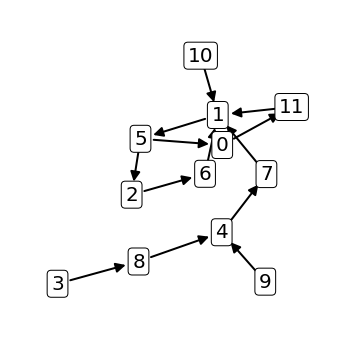

In [3]:
draw(D2, latexlabels=False, node_shape='b', prog='fdp');

In [4]:
dout

{3: 8, 0: 11, 1: 5, 2: 6, 4: 7}

In [5]:
def sort_mdf(G, eqsn):
    C = nx.condensation(G)
    order = []
    for n in nx.topological_sort(C):
        filtereqs = {elt for elt in C.nodes[n]['members'] if elt in eqsn}
        if filtereqs:
            order.append(filtereqs)
    return order

In [6]:
order = sort_mdf(D2, alleqs)
order

[{3}, {4}, {0, 1, 2}]

MDF_IDF

In [7]:
def simplify_ordered(notation):
    if len(notation)==2 and isinstance(notation[0],list):
        return notation
    else:
        return [eq for out,eq in notation]

In [8]:
def notation_mdf_idf(order, dout, notation=None, mergers=None):
    mergers = mergers if mergers != None else []
    merged_notation = []
    for elt in order:
        if len(elt)==1:
            eqn = next(iter(elt))
            merged_notation.append(notation[eqn])
        else: # we hit a 'component'
            # TODO: need to work this one out for notation
            # This is where the IDF part kicks in, otherwise would have to tear here
            outs = [out for eqn in elt for out in dout[eqn]]
            # Need to simplify ordered 
            eqs = [nt for comp in elt for nt in (notation[comp] if comp in mergers else [comp])]
            eqs += ['ceq{}'.format(out) for comp in elt for out in dout[comp] if comp in mergers]
            merged_notation.append((outs, eqs))
    if len(merged_notation)==1:
        return merged_notation[0]
    else:
        return merged_notation

In [9]:
dout

{3: 8, 0: 11, 1: 5, 2: 6, 4: 7}

In [89]:
doutnot = {key: (var,key) for key,var in dout.items()}

In [11]:
doutls = {key: [var] for key,var in dout.items()}

Merge

In [12]:
#D2 = nx.DiGraph([(1,4), (4,2), (2,5), (5,1), (3,6), (6,1)])

In [16]:
def merge(G, mergelts, mgroupname, mergewithold=True, solvefor=None):
    solvefor = [] if solvefor == None else solvefor
    edges = G.edges()
    mergededges = [(fr,to) for fr,to in edges if fr in mergelts or to in mergelts]
    outs = {to for fr,to in edges if fr in mergelts and not all([elt in mergelts for elt in D2.successors(to)])}
    outs.union({elt for elt in solvefor}) # for every terminal node can have one solvefor
    ins = {fr for fr,to in edges if to in mergelts and not any([elt in mergelts for elt in D2.predecessors(fr)])}
    newedges = [(fr, mgroupname) for fr in ins]+[(mgroupname, to) for to in outs]
    if mergewithold:
        oldedges = [(fr, to) for fr,to in edges if fr not in mergelts and to not in mergelts]
        newedges += oldedges
    return nx.DiGraph(newedges),nx.DiGraph(mergededges), outs

In [59]:
order = sort_mdf(D2, alleqs)
notation_mdf_idf(order, doutls, doutnot)

NameError: name 'sort_mdf' is not defined

In [15]:
mergelts = [4,0,1]
otherelts = [elt for elt in alleqs if elt not in mergelts]
order = sort_mdf(D2, mergelts)
notation_m1 = notation_mdf_idf(order, doutls, doutnot)
newdout = {key:var for key,var in doutls.items() if key in otherelts}
newdoutnot = {key:var for key,var in doutnot.items() if key in otherelts}

In [16]:
notation_m1

[(7, 4), ([11, 5], [0, 1])]

In [17]:
newdout

{3: [8], 2: [6]}

In [18]:
D3, outs = merge(D2, mergelts, 'm1')
newdout.update({'m1': ['cp{}'.format(elt) for elt in  outs]})
newdoutnot.update({'m1': notation_m1})

In [19]:
order = sort_mdf(D3, [2,3,'m1'])

In [20]:
order

[{3}, {2, 'm1'}]

In [21]:
newdout, newdoutnot

({3: [8], 2: [6], 'm1': ['cp5']},
 {3: (8, 3), 2: (6, 2), 'm1': [(7, 4), ([11, 5], [0, 1])]})

In [22]:
notation_mdf_idf(order, newdout, newdoutnot, ['m1'])

[(8, 3), ([6, 'cp5'], [2, (7, 4), ([11, 5], [0, 1]), 'ceqcp5'])]

In [308]:
D4 = merge(D3, [0,2], 'm2')

## Next step
Assume we have a graph with no cycles; </br>
then we can execute each node, for example through IDF(i.e. residualize), but this might require copy variables in some cases </br>
if there is a cycle, we can either tear it, or merge it and make it a problem for the layer below </br>
technically we can merge elements of a cycle into multiple different merges but that wouldn't remove the cycle

### Residualize (aka idf)
Only associated with notation or both

## Merge demo

In [82]:
mergelts1 = [0,1,4]
mergelts2 = [2,3]
compGraph, newcomp, outs = merge(D2, mergelts1, 'm1', False)

In [83]:
newcomp.edges()

OutEdgeView([(5, 0), (0, 11), (11, 1), (6, 1), (1, 5), (7, 1), (10, 1), (8, 4), (4, 7), (9, 4)])

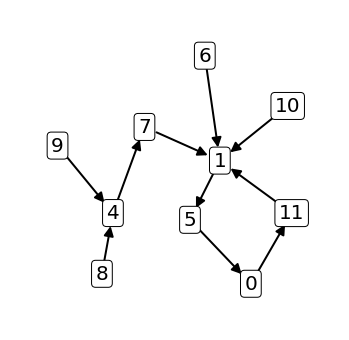

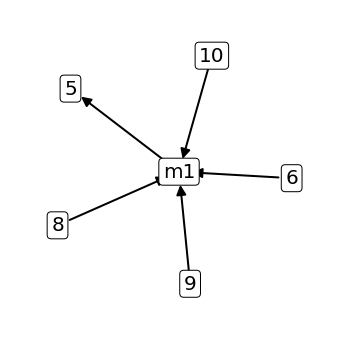

In [86]:
draw(newcomp, latexlabels=False, node_shape='b', prog='fdp')
draw(compGraph, latexlabels=False, node_shape='b', prog='fdp');

In [85]:
outs

{5}

In [119]:
newGraph, m1comp,_ = merge(D2, mergelts1, 'm1')
newGraph, m2comp,_ = merge(newGraph, mergelts2, 'm2')

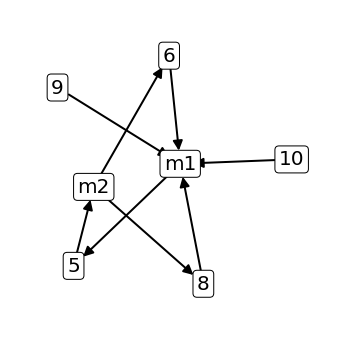

In [115]:
draw(newGraph, latexlabels=False, node_shape='b', prog='fdp');

## Sequencing

In [203]:
def forcetolist(obj):
    return [obj] if not isinstance(obj, list) else obj
def flatten(lst):
    [elt for interm in lst for elt in forcetolist(interm)]

In [204]:
def notation_seq(order, residuals, node_notation):
    notation_out = [elt for node in order for elt in forcetolist(node_notation[node])]
    if residuals:
        allsolvefor, residuals_only = zip(*residuals)
        notation_out += residuals_only
        return (list(allsolvefor), notation_out)
    else:
        return notation_out

In [149]:
notation_seq([1, 2, 'm1'], [('cpa', 'ceq')], {1:('x',1), 2:('y',2), 'm1': (['a'],[3]), 'ceq':'ceq'})

(['cpa'], ['x', 1, 'y', 2, ['a'], [3], 'ceq'])

In [211]:
def residualize(G, nodes, merged_nodes, node_notation):
    edges = G.edges()
    new_edges = []
    new_notation = node_notation.copy()
    counter = 0
    res = []
    order = []
    for fr,to in edges:
        if fr in nodes:
            new_edges.append((to, fr))
            new_notation[fr] = fr
            res.append((to, fr))
        elif fr in merged_nodes:
            copyvarname = 'cp{}'.format(to)
            eqname = 'ceq_{}'.format(fr)
            new_edges.append((fr, copyvarname))
            new_edges.append((copyvarname, eqname))
            new_edges.append((to, eqname))
            new_notation[eqname]=eqname
            order.append((fr))
            res.append((to, eqname))
            counter+=1
        else:
            new_edges.append((fr,to))
    return new_edges, new_notation, order, res

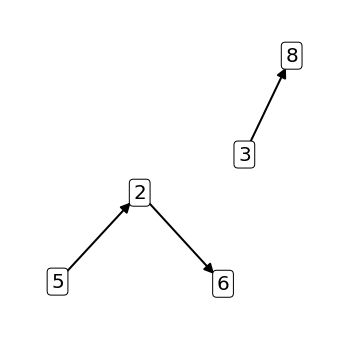

In [121]:
draw(m2comp, latexlabels=False, node_shape='b', prog='fdp');

In [212]:
def tear_notation(comp, order, teareq, teareqmerged, notation):
    D2res, notation_new, orderres, res = residualize(comp, teareq, teareqmerged, notation)
    return notation_seq(order+orderres, res, notation_new), notation_new

In [213]:
notn0 = {key: (var,key) for key,var in dout.items()}

In [214]:
m1not, notn1 = tear_notation(m1comp, [4,1], [0], [], notn0)
notn1['m1'] = m1not
m2not, notn2 = tear_notation(m2comp, [2,3], [], [], notn1)
notn2['m2'] = m2not

In [215]:
m1not

([11], [(7, 4), (5, 1), 0])

In [216]:
m2not

[(6, 2), (8, 3)]

In [217]:
tear_notation(newGraph, ['m2'], [], ['m1'], notn2)

(([5], [(6, 2), (8, 3), ([11], [(7, 4), (5, 1), 0]), 'ceq_m1']),
 {3: (8, 3),
  0: 0,
  1: (5, 1),
  2: (6, 2),
  4: (7, 4),
  'm1': ([11], [(7, 4), (5, 1), 0]),
  'm2': [(6, 2), (8, 3)],
  'ceq_m1': 'ceq_m1'})

In [99]:
D2res, notat2, res = residualize(newcomp, [0], [], doutnot)

In [108]:
notation_seq([4,1], res, notat2)

([11], [(7, 4), (5, 1), 0])

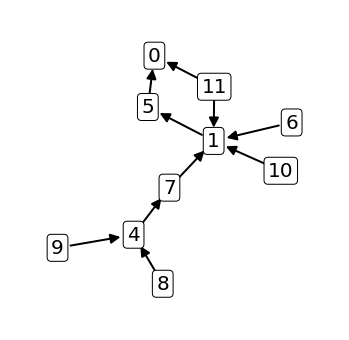

In [100]:
draw(nx.DiGraph(D2res), latexlabels=False, node_shape='b', prog='neato');

In [54]:
tear(('m1', x1))
# residualize m1 --res--> notation_seq(order, ('x',ceq))

NameError: name 'tear' is not defined

In [55]:
residualize(D2, [2], [3], doutnot)

([(5, 0),
  (5, 2),
  (0, 11),
  (6, 1),
  (1, 5),
  (7, 1),
  (10, 1),
  (11, 1),
  (6, 2),
  (8, 4),
  (4, 7),
  (9, 4),
  (3, 'cp8'),
  ('cp8', 'ceq0'),
  (8, 'ceq0')],
 {3: (8, 3), 0: (11, 0), 1: (5, 1), 2: 2, 4: (7, 4), 'ceq0': 'ceq0'},
 [(6, 2), (8, 'ceq0')])

In [112]:
merger_nodes = ['m1']

In [ ]:
newdout.update({'m1': ['cp{}'.format(elt) for elt in  outs]})

In [117]:
def residualize(order, nodes, mergednodes, notation, dout):
    # assume order is topologically sorted
    merged_notation = [notation[eqn] for eqn in order]
    outs = [out for eqn in nodes for out in dout[eqn]]
    # Need to simplify ordered 
    for elt in nodes:
        eqs = [nt for comp in elt for nt in (notation[comp] if comp in mergednodes else [comp])]
        eqs += ['ceq{}'.format(out) for comp in elt for out in dout[comp] if comp in mergednodes]
    merged_notation.append((outs, eqs))

In [ ]:
residualize

In [79]:
scc = filter(lambda x: len(x)>1, nx.strongly_connected_components(D2))

In [81]:
m1 = list(scc)[0]

In [82]:
m1

{0, 1, 2, 5, 6, 11}

In [86]:
newGraph, newComp, _ = merge(D2, m1, 'm1')

In [91]:
eqs = [node for node in m1 if node in alleqs]
solvefor = [dout[eqn] for eqn in eqs]

In [102]:
mergednodes = [elt for elt in newGraph.nodes() if elt in alleqs+['m1']]

In [103]:
doutnotnew = {key:val for key,val in doutnot.items() if key in mergednodes}
doutnotnew['m1'] = (solvefor, eqs)

In [104]:
doutnotnew

{3: (8, 3), 4: (7, 4), 'm1': ([11, 5, 6], [0, 1, 2])}

In [109]:
order = [node for node in nx.topological_sort(newGraph) if node in alleqs+['m1']] #filter out variables
notation_seq(order, doutnotnew)

[(8, 3), (7, 4), ([11, 5, 6], [0, 1, 2])]

In [110]:
order

[3, 4, 'm1']

## Merge function build up

In [72]:
outs = {to for fr,to in D2.edges() if fr in mergelts and not any([elt in mergelts for elt in D2.successors(to)])}
ins = {fr for fr,to in D2.edges() if to in mergelts and not any([elt in mergelts for elt in D2.predecessors(fr)])}

In [79]:
mgroup = 'm1'
newedges = [(fr, mgroup) for fr in ins]+[(mgroup, to) for to in ins]

In [81]:
oldedges = [(fr, to) for fr,to in D2.edges() if fr not in mergelts and to not in mergelts]

In [83]:
oldedges+newedges

[(4, 0),
 (4, 2),
 (0, 9),
 (8, 0),
 (6, 2),
 (2, 7),
 (9, 2),
 (8, 'm1'),
 (9, 'm1'),
 (6, 'm1'),
 ('m1', 8),
 ('m1', 9),
 ('m1', 6)]

In [80]:
newedges

[(8, 'm1'), (9, 'm1'), (6, 'm1'), ('m1', 8), ('m1', 9), ('m1', 6)]

### Partitions (i.e. modules)

In [14]:
from notation import generate_execution

Copy variable not needed when we only have one discipline in an implicit mode

In [25]:
ex1 = [('acopy', [('c', [('b', 1), 2]), (['a'], [3]), -1])] 
# ends up being equivalent to 
ex1_simple = [('aregular', [('c', [('b',1), 2]), 3])] 

In [26]:
generate_execution(ex1)

[('solver', 0, 1, 'acopy', [-1]),
 ('solver', 1, 2, 'c', [2]),
 ('exp', 2, 'b', 1),
 ('solver', 1, 3, ['a'], [3])]

In [27]:
generate_execution(ex1_simple)

[('solver', 0, 1, 'aregular', [3]),
 ('solver', 1, 2, 'c', [2]),
 ('exp', 2, 'b', 1)]

But with more than two disciplines on the tearing variable we need it <-- some tearings might lead to fewer copy variables?

In [29]:
ex2 = [('acopy', [('c', [('b', 1), 2]), (['a', 'x'], [3, 4]), -1])] # two levels, with multiple siblings with solvers at lower level

In [30]:
generate_execution(ex2)

[('solver', 0, 1, 'acopy', [-1]),
 ('solver', 1, 2, 'c', [2]),
 ('exp', 2, 'b', 1),
 ('solver', 1, 3, ['a', 'x'], [3, 4])]

## Demo

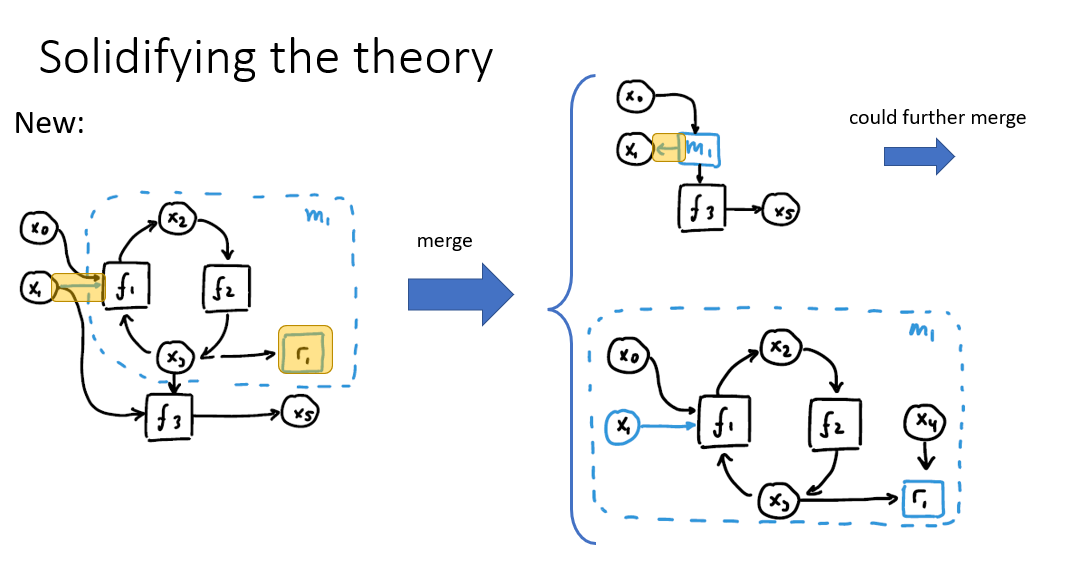

In [82]:
root = nx.DiGraph([('x_0', 'f_1'), ('f_1', 'x_2'), ('x_1', 'f_1'), ('x_2', 'f_2'), ('f_2', 'x_3'), ('x_3', 'f_1'), ('x_3', 'f_3'), 
                   ('x_1', 'f_3'), ('f_3', 'x_5'), ('x_3', 'r_1'), ('x_4', 'r_1')])

In [3]:
def circular_vars(graph):
    return {elt:'o' if elt in ['x_0','x_1','x_2','x_3','x_4','x_5'] else 's' for elt in graph.nodes()}

In [32]:
def drawfull(graph, prog='neato'):
    draw(graph, node_shape=circular_vars(graph), arc=0.1, prog=prog);

In [4]:
#draw(root, node_shape=node_shapes, arc=0.1, prog='neato');

In [47]:
def merge(G, mergelts, mgroupname, mergewithold=True, solvefor=None, solvefortable=None):
    solvefor = [] if solvefor == None else solvefor
    solvefortable = dict() if solvefortable == None else solvefortable
    allsolvevars = set()
    for solvevar, res in solvefor:
        mergelts.append(res)
        allsolvevars.add(solvevar)
    edges = G.edges()
    mergededges = [(fr,to) for fr,to in edges if fr in mergelts or to in mergelts]
    outs = {to for fr,to in edges if fr in mergelts and not all([elt in mergelts for elt in G.successors(to)])}
    outs = outs.union(allsolvevars) # for every terminal node can have one solvefor
    ins = {fr for fr,to in edges if (
        to in mergelts 
        and not any([elt in mergelts for elt in G.predecessors(fr)]) 
        and fr not in allsolvevars)}
    newedges = [(fr, mgroupname) for fr in ins]+[(mgroupname, to) for to in outs]
    if mergewithold:
        oldedges = [(fr, to) for fr,to in edges if fr not in mergelts and to not in mergelts]
        newedges += oldedges
    solvefortable = solvefortable.copy()
    solvefortable[mgroupname] = solvefor
    return nx.DiGraph(newedges),nx.DiGraph(mergededges), solvefortable

In [83]:
ch1, ch2, solvefortable = merge(root, ['f_1','f_2'], 'm1', solvefor=[('x_1', 'r_1')])

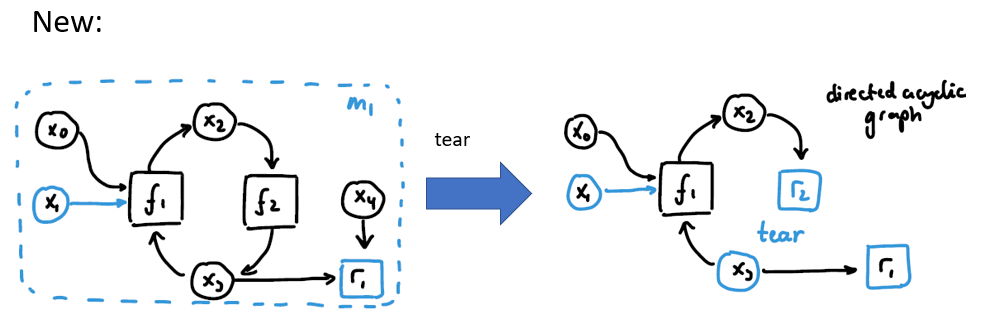

In [73]:
# old implmentation:
# def standardize(G, nodes, notation):
#     new_notation = notation.copy()
#     edges = [(to,fr) if fr in nodes else (fr,to) for fr,to in G.edges()]
#     for elt in nodes:
#         new_notation[nodes] = notation[nodes][1]
#     return nx.DiGraph(edges), new_notation

In [ ]:
def standardize(graph_map, solvefor, external_res, graph_name, comp_name, var):
    graph_map = graph_map.copy()
    graph = graph_map[graph_name]
    # invert direction
    edges = [(to,fr) if fr==comp_name else (fr,to) for fr,to in graph.edges()]
    graph_map[comp_name] = nx.DiGraph(edges)
    comp_graph = graph_map[comp_name]
    # test for which case
    pred = comp_graph.predecessors(var)
    if pred: # case 1 - the 'trivial' case
        if comp_name in graph_map:
            standardize(graph_map, solvefor, external_res, comp_name, str(pred[1]), var)
        else: # if we have a leaf node
            pass
    else: # case 2 - the interesting case
        res = solvefor[comp_name][var]
        solvefor[comp_name].pop(var)
        external_res[comp_name].append(res)
        # update solvefor of merged
        solvefor[graph_name][var] = comp_name
    # update notation ?
    
    return graph_map, solvefor, external_res

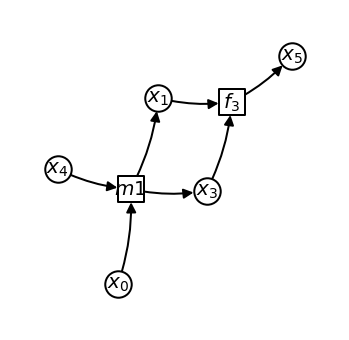

In [84]:
drawfull(ch1)

In [77]:
notation = {'m1': (['x_1', 'x_3'], [('x_2', 'f_1'), ('x_2', 'f_5'), 'r_1', 'f_2'])}

In [87]:
st, newnotation = standardize(ch1, 'm1', notation)

In [88]:
newnotation

{'m1': [('x_2', 'f_1'), ('x_2', 'f_5'), 'r_1', 'f_2']}

In [58]:
def tear(G, mgroupname, solvefor, solvefortable):
    edges = [(to,fr) if (to,fr) in solvefor else (fr,to) for fr,to in G.edges()]
    solvefortable = solvefortable.copy()
    solvefortable[mgroupname].extend(solvefor)
    notation[mgroupname] = 
    return nx.DiGraph(edges), solvefortable

In [66]:
def forcetolist(obj):
    return [obj] if not isinstance(obj, list) else obj
def flatten(lst):
    [elt for interm in lst for elt in forcetolist(interm)]

In [69]:
def executable(order, solvefor, node_notation):
    notation_out = [elt for node in order for elt in forcetolist(node_notation[node])]
    if solvefor:
        allsolvefor, residuals_only = zip(*solvefor)
        notation_out += residuals_only
        return (list(allsolvefor), notation_out)
    else:
        return notation_out

In [60]:
ch11, solvefor2 = tear(root, 'm1', [('x_3', 'f_2')], solvefortable)

In [76]:
solvefor2

{'m1': [('x_1', 'r_1'), ('x_3', 'f_2')]}

In [64]:
notation_out ={
    'f_1': ('x_2','f_1'),
    'f_3': ('x_2','f_5')
}

In [72]:
executable(['f_1', 'f_3'], solvefor2['m1'], notation_out)

(['x_1', 'x_3'], [('x_2', 'f_1'), ('x_2', 'f_5'), 'r_1', 'f_2'])

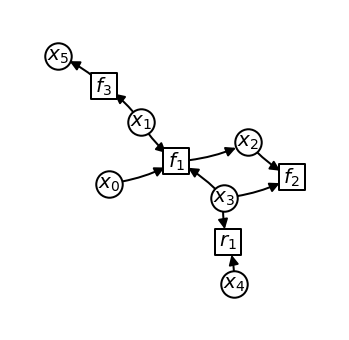

In [38]:
drawfull(ch11)